In [1]:
using DrWatson
quickactivate(@__DIR__)

import Baysor as B
import CairoMakie as MK
import Colors
import Images
import MAT
import MultivariateStats
import Plots
import CSV

using Clustering
using Distances
using SparseArrays
using ProgressMeter
using MatrixMarket
using DataFrames
using DataFramesMeta
using NearestNeighbors
using Statistics
using StatsBase

MK.activate!(type = "png");

## Load data

In [2]:
@time df_spatial, gene_names = B.load_df(datadir("exp_pro/allen_smfish/baysor/segmentation.csv"));
df_spatial[!, :x] = round.(Int, 10 .* (df_spatial.x .- minimum(df_spatial.x)));
df_spatial[!, :y] = round.(Int, 10 .* (df_spatial.y .- minimum(df_spatial.y)));
length(gene_names)

 30.167091 seconds (26.88 M allocations: 1.553 GiB, 5.42% gc time, 75.46% compilation time)


22

In [ ]:
@time neighb_cm = B.neighborhood_count_matrix(df_spatial, 40);
@time color_transformation = B.gene_composition_transformation(neighb_cm, df_spatial.confidence; sample_size=20000, spread=2.0, min_dist=0.1);
@time color_emb = B.transform(color_transformation, neighb_cm);

In [ ]:
@time gene_colors = B.gene_composition_colors(color_emb, lrange=(10, 60));
df_spatial[!, :color] = gene_colors;

## Coloring examples

In [ ]:
Plots.theme(:default, framestyle = :box, legendfontsize=10, tickfontsize=10)

In [ ]:
Plots.pyplot()

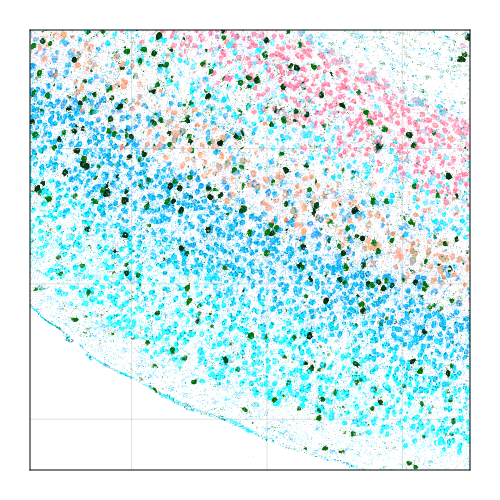

In [20]:
sub_lims = [((11000, 13000), (12000, 13500)), ((11500, 13500), (8750, 10250))];

fig = B.plot_molecules(df_spatial, color=:ncv_color, markersize=0.5, xlims=(5000, 18000), ylims=(2500, 15500), size=(500, 500))
# for ((xs, xe), (ys, ye)) in sub_lims
#     Plots.plot!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color="black", label="", lw=3.0, alpha=0.75)
# end

MK.save(plotsdir("segmentation_free/allen_smfish/gene_coloring.png"), fig)
fig

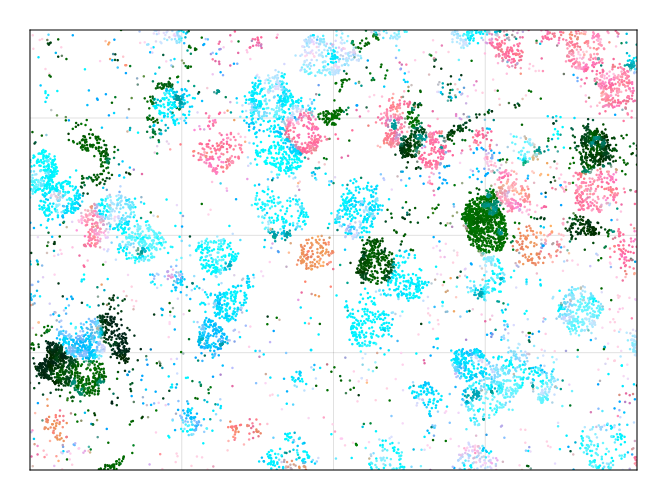

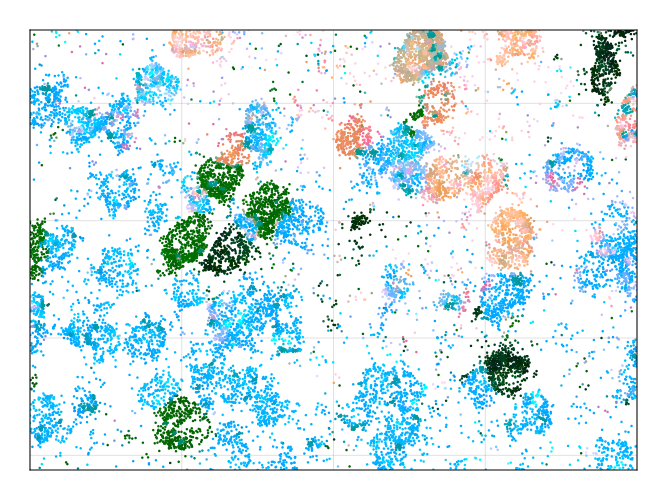

In [21]:
for (i,((xs, xe), (ys, ye))) in enumerate(sub_lims)
    p_df = @where(df_spatial, :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye)
    fig = B.plot_molecules(p_df, color=:ncv_color, markersize=2.5, size=(xe - xs, ye - ys) ./ 3)
    MK.save(plotsdir("segmentation_free/allen_smfish/gene_coloring_e$i.png"), fig)
    display(fig)
end

## Varying *k*

In [6]:
k_vals = [5, 50, 500, 2000]
gene_colors_per_k = []
@showprogress for k in k_vals
    neighb_cm = Matrix{Float64}(B.neighborhood_count_matrix(df_spatial, k, normalize=false));
    color_transformation = B.gene_composition_transformation(neighb_cm, df_spatial.confidence; sample_size=10000, spread=2.0, min_dist=0.1);
    color_emb = B.transform(color_transformation, neighb_cm);
    gene_colors = B.gene_composition_colors(color_emb);
    push!(gene_colors_per_k, gene_colors)
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:13:28


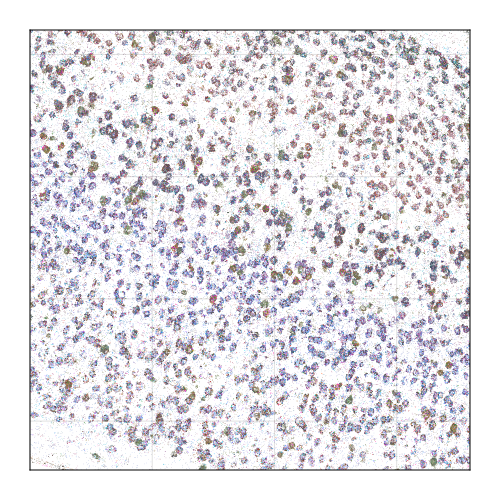

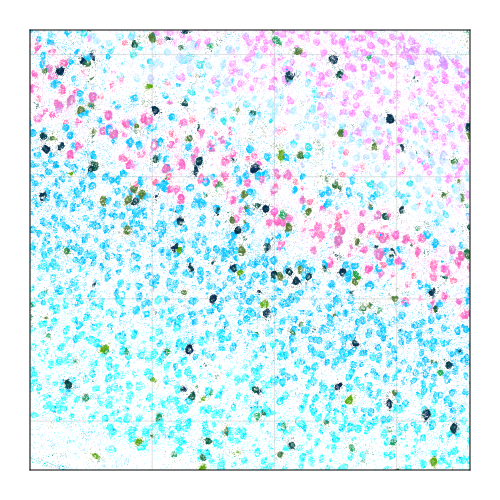

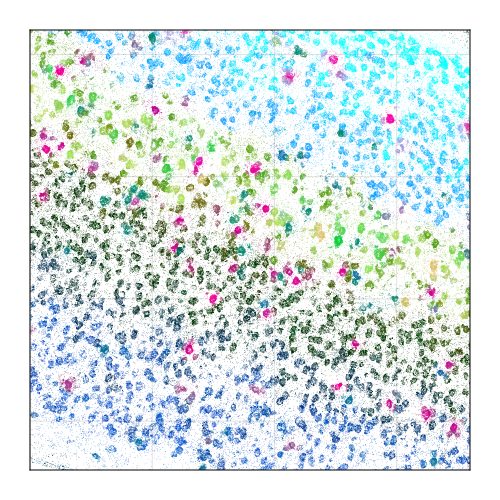

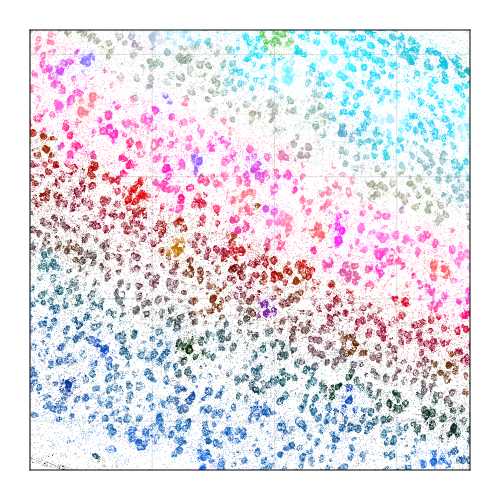

In [36]:
for (k, colors) in zip(k_vals, gene_colors_per_k)
    fig = B.plot_molecules(df_spatial, color=colors, markersize=0.5, size=(500, 500))
#     MK.xlims!(MK.current_axis(), (5000, 19000))
#     MK.ylims!(MK.current_axis(), (3000, 17000))
    MK.xlims!(MK.current_axis(), (10000, 19000))
    MK.ylims!(MK.current_axis(), (4000, 13000))
    MK.save(plotsdir("segmentation_free/allen_smfish/vis_$(k)_nn.png"), fig)
    display(fig)
end

## Method scheme

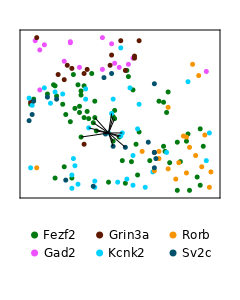

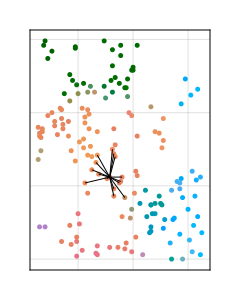

In [129]:
(xs,xe), (ys,ye) = (12130, 12250), (9750, 9900)

p_df = @where(df_spatial, :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye) |> deepcopy;
p_df = @where(p_df, (B.count_array(:gene)[:gene] .> 15), .!in.(gene_names[:gene], Ref(["Mpped1"])))
p_df.y .*= -1

p_size = (xe - xs, ye - ys) .* 2
fig1 = B.plot_molecules(p_df, annotation=gene_names[p_df.gene], markersize=5, size=p_size, legend=false, axis_kwargs=(xgridvisible=false, ygridvisible=false))
fig1[2,1] = MK.Legend(fig1, fig1.current_axis[], framevisible=false, labelsize=12, orientation=:horizontal, nbanks=2, patchsize=(10,10), markersize=7, markerstrokewidth=0, tellheight=true)

fig2 = B.plot_molecules(p_df, color=:ncv_color, markersize=5, size=p_size) # , alpha=0.75

# B.plot_cell_borders_polygons(p_df, annotation=gene_names[p_df.gene], ms=5, size=(500, 1000), legend=:bottomright, xticks=x_ticks, yticks=y_ticks)
# Plots.annotate!(p_df.x, p_df.y, 1:size(p_df, 1))

t_pos_data = B.position_data(p_df);
# t_id = 103
# t_pd = t_pos_data[:, knn(KDTree(t_pos_data), t_pos_data[:,[t_id]], 16, true)[1][1][2:end]];
cent_pos = [12183.0, -9844.0];
t_pd = t_pos_data[:, knn(KDTree(t_pos_data), cent_pos, 16, true)[1][2:end]];
for fig in [fig1, fig2]
    for col in eachcol(t_pd)
#         MK.plot!(pl, [col[1], t_pos_data[1,t_id]], [col[2], t_pos_data[2,t_id]], label="", color="black", lw=1.5)
        MK.lines!(fig.current_axis[], [col[1], cent_pos[1]], [col[2], cent_pos[2]], label="", color="black", lw=1.5)
    end
end

MK.save(plotsdir("segmentation_free/allen_smfish/knns_genes.pdf"), fig2)
MK.save(plotsdir("segmentation_free/allen_smfish/knns_expr.pdf"), fig2)

display(fig1)
display(fig2)

## Local Expression Vectors

In [130]:
module T

import Baysor
using DataFrames

function build_coexpression_mtx(expr_mat::Matrix{Int}, g1::Int, g2::Int, max_expr::Int=maximum(expr_mat[[g1, g2],:]))
    coexpr_mat = zeros(Int, max_expr, max_expr);
    for i in 1:size(expr_mat, 2)
        coexpr_mat[expr_mat[g1, i] + 1, expr_mat[g2, i] + 1] += 1
    end

    coexpr_mat[1, 1] = 0;
    return coexpr_mat ./ sum(coexpr_mat)
end

end

Main.T

In [ ]:
@time B.append_confidence!(df_spatial, nn_id=16);
@time adjacent_points, adjacent_weights = B.build_molecule_graph(df_spatial, filter=false);

In [ ]:
t_nm, t_ids = B.extract_filtered_local_vectors(df_spatial, adjacent_points, 40; confidence=nothing);

all(t_ids .== 1:size(df_spatial, 1))
all(abs.(t_nm .- neighb_cm) .< 1e-5)

In [ ]:
g1, g2 = [findfirst(gene_names .== g) for g in ["Gad2", "Satb2"]];
color_lims = (0., 5.);

In [ ]:
@time mol_clust4 = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; 
    n_clusters=4, max_iters=2000, n_iters_without_update=100);

In [ ]:
# Baysor.plot_cell_borders_polygons(df_spatial, annotation=mol_clust4.assignment, ms=1.0, xlims=(1800, 23300), ylims=(1500, 21000), size=(700, 700))

### Wrong expression measurements

In [ ]:
t_nm, t_ids = B.extract_filtered_local_vectors(df_spatial, adjacent_points, 40; confidence=nothing, normalize=false);
t_nm2, t_ids2 = B.extract_filtered_local_vectors(df_spatial, adjacent_points, 40; normalize=false);
t_nm3, t_ids3 = B.extract_filtered_local_vectors(df_spatial, adjacent_points, clust_per_mol=mol_clust4.assignment, 40, normalize=false);

In [ ]:
plot_df = vcat([DataFrame(Dict(:expr => m[g2, m[g1,:] .> m[g2,:]], :type => t)) for (t, m) in zip([:t1, :t2, :t3], (t_nm, t_nm2, t_nm3))]...);
t_probs = [Baysor.prob_array(m[g2, m[g1,:] .> m[g2,:]] .+ 1) for m in (t_nm, t_nm2, t_nm3)]

plt = Plots.bar((1:length(t_probs[3])) .- 0.25, t_probs[3], bar_width=0.2, xticks=(1:10, ["$(x / 40)" for x in 0:9]), 
    label="Clustering", xlabel="Expression of a wrong marker", ylabel="Fraction of molecules", size=(600, 300))
Plots.bar!(t_probs[2], bar_width=0.2, label="Noise filtration")
Plots.bar!((1:length(t_probs[1])) .+ 0.25, t_probs[1], bar_width=0.2, label="Basic")

Plots.savefig("./plots/allen_sm_fish/patches_wrong_frac.pdf")
plt

In [ ]:
plt = Plots.heatmap(log10.(T.build_coexpression_mtx(t_nm3, g1, g2, 32) .+ offset)[:,1:25], clims=color_lims, size=(500, 200), colorbar_title="log10(molecule frac)")
Plots.savefig("./plots/allen_sm_fish/patches_heatmap_legend.pdf")
plt

In [ ]:
offset = 1e-5
color_lims = (-5., 0.)
t_plots = []
for (tit,m) in zip(["Noise molecules", "Real molecules, no adjustment", "Real molecules, adjustment by confidence", "Real molecules, adjustment by cluster"], 
        (t_nm[:, df_spatial.confidence .< 0.05], t_nm[:, df_spatial.confidence .> 0.75], t_nm2, t_nm3))
    plt = Plots.heatmap(log10.(T.build_coexpression_mtx(m, g1, g2, 32) .+ offset)[:,1:25], clims=color_lims, legend=:none, 
        xlims=(0.5, 25.5), ylims=(0.5, 32.5), xlabel="Satb2 expression fraction", ylabel="Gad2 expression fraction", title=tit,
        xticks=((0:5:25),  ["$(f/40)" for f in 0:5:25]), yticks=((0:5:30),  ["$(f/40)" for f in 0:5:30]))
    plt = Plots.plot!(range(0, 18.75, length=100), range(25, 0, length=100), color="#6be4ff", lw=2.0, alpha=0.75)
    plt = Plots.plot!(range(0, 15, length=100), range(20, 0, length=100), color="#6be4ff", lw=2.0, alpha=0.75)
    push!(t_plots, plt)
end

plt = Plots.plot(t_plots..., layout=(2, 2), size=(1000, 1000))
Plots.savefig("./plots/allen_sm_fish/patches_heatmaps.pdf")

plt

### Different number of NNs

In [ ]:
sample_ids = Baysor.select_ids_uniformly(df_spatial.x, df_spatial.y, df_spatial.confidence, n=20000);

coord_df = deepcopy(df_spatial[sample_ids, 2:end]);
coord_df[!, :gene] = gene_names[coord_df.gene];
CSV.write("../cache/allen_coord_df.csv", coord_df);
p
@showprogress for nn in [5, 50, 300, 500, 2000]
    neighb_cm = Baysor.neighborhood_count_matrix(df_spatial, nn, normalize=false);
    mmwrite("../cache/allen_neighb_$nn.mm", SparseMatrixCSC(neighb_cm))
    mmwrite("../cache/allen_neighb_sample_$nn.mm", SparseMatrixCSC(neighb_cm[:, sample_ids]))
end

CSV.write("../cache/allen_gene_names.csv", DataFrame([gene_names], [:gene]));

## Clustering

In [ ]:
confidence_nn_id = Baysor.default_param_value(:confidence_nn_id, 30);
B.append_confidence!(df_spatial, nn_id=confidence_nn_id);

In [ ]:
@time adjacent_points, adjacent_weights = B.build_molecule_graph(df_spatial, filter=false, adjacency_type=:both, k_adj=30);

In [ ]:
@time polygons = B.boundary_polygons(df_spatial, df_spatial.cell; grid_step=2.0, bandwidth=6.5);

#### 4 clusters

In [ ]:
@time mol_clust4 = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; 
    n_clusters=4, max_iters=10000, n_iters_without_update=100);

In [ ]:
@time mol_clust4 = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; 
    n_clusters=4, max_iters=20, n_iters_without_update=100);

In [ ]:
exprs_norm = copy((mol_clust4.exprs ./ sum(mol_clust4.exprs, dims=1))');
plt = B.clustermap(exprs_norm, gene_names, cell_ord=1:size(exprs_norm, 2), diag_genes=true,
    xticks=1:size(exprs_norm, 2), color=:OrRd_9, xlabel="Cluster", size=(350, 500), tickfontsize=12, labelfontsize=12)[1]

In [ ]:
Baysor.plot_cell_borders_polygons(df_spatial, annotation=mol_clust4.assignment, ms=1.0)

#### 8 clusters

In [ ]:
@time mol_clust8 = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; n_clusters=8, max_iters=2000, n_iters_without_update=100);

In [ ]:
@time mol_clust8_v2 = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; n_clusters=8, max_iters=2000, 
    n_iters_without_update=100, min_mols_per_cell=30);

In [ ]:
Baysor.plot_cell_borders_polygons(df_spatial, annotation=mol_clust8.assignment, ms=1.0, xlims=(1800, 23300), ylims=(1500, 21000), size=(1000, 1000))

In [ ]:
gene_ord = sortperm(gene_names, rev=true)
Plots.heatmap((mol_clust8_v2.exprs')[gene_ord, :], yticks=(1:length(gene_names), gene_names[gene_ord]), xticks=1:size(mol_clust8_v2.exprs, 1))

#### 10 clusters

In [ ]:
@time mol_clust10 = B.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; n_clusters=10, max_iters=2000, n_iters_without_update=50);

In [ ]:
sub_lims = [((6000, 8000), (11000, 12500)), ((12500, 14500), (13500, 15000))];

plt = Baysor.plot_cell_borders_polygons(df_spatial, annotation=mol_clust10.assignment, ms=1.0, xlims=(5000, 18000), ylims=(2500, 15500), 
    size=(1000, 1000), ticks=false, legend=:bottomleft, legendfontsize=20, legend_title="Cluster", legendtitlefontsize=18)
for ((xs, xe), (ys, ye)) in sub_lims
    Plots.plot!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color="black", label="", lw=3.0, alpha=0.75)
end

# Plots.savefig("./plots/allen_sm_fish/molecule_clustering.png")
plt

In [ ]:
sub_lims = [((12500, 14500), (13500, 15000)), ((12000, 14000), (5500, 7000))];

plt = Baysor.plot_cell_borders_polygons(df_spatial, annotation=mol_clust10.assignment, ms=1.0, xlims=(5000, 18000), ylims=(2500, 15500), 
    size=(1000, 1000), ticks=false, legend=:bottomleft, legendfontsize=20, legend_title="Cluster", legendtitlefontsize=22)
for ((xs, xe), (ys, ye)) in sub_lims
    Plots.plot!([xs, xs, xe, xe, xs], [ys, ye, ye, ys, ys], color="black", label="", lw=3.0, alpha=0.75)
end

Plots.savefig("./plots/allen_sm_fish/molecule_clustering.png")
plt

In [ ]:
df_spatial[!, :cluster] = mol_clust10.assignment;

for (i,((xs, xe), (ys, ye))) in enumerate(sub_lims)
    p_df = @where(df_spatial, :x .>= xs, :x .<= xe, :y .>= ys, :y .<= ye)
    plt = B.plot_cell_borders_polygons(p_df, annotation=p_df.cluster, ms=2.5, size=(xe - xs, ye - ys) .* 0.25, ticks=false, legend=:none)
    Plots.savefig("./plots/allen_sm_fish/mol_clustering_e$(i).png")
    display(plt)
end

In [ ]:
exprs_norm = copy((mol_clust10.exprs ./ sum(mol_clust10.exprs, dims=1))');
plt = B.clustermap(exprs_norm, gene_names, cell_ord=1:size(exprs_norm, 2), diag_genes=true,
    xticks=1:size(exprs_norm, 2), color=:OrRd_9, xlabel="Cluster", size=(350, 500), tickfontsize=12, labelfontsize=12)[1]

Plots.savefig("./plots/allen_sm_fish/cluster_centers.png")
plt

#### 20 clusters

In [ ]:
@time mol_clust20 = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; n_clusters=20, max_iters=2000, 
    n_iters_without_update=100, min_mols_per_cell=30);

In [ ]:
clust_order = sortperm(vec(mol_clust20.exprs[:, gene_names .== "Gad2"] .> 0.01));

In [ ]:
Baysor.plot_cell_borders_polygons(df_spatial, annotation=sortperm(clust_order)[mol_clust20.assignment], ms=1.0, xlims=(1800, 23300), ylims=(1500, 21000), size=(1000, 1000))

In [ ]:
gene_ord = sortperm(gene_names, rev=true)
Plots.heatmap((mol_clust20.exprs')[gene_ord, clust_order], yticks=(1:length(gene_names), gene_names[gene_ord]), xticks=1:size(mol_clust20.exprs, 1))

In [ ]:
@time mol_clust20_v2 = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; n_clusters=20, max_iters=10000, 
    n_iters_without_update=100, min_mols_per_cell=30);

In [ ]:
clust_order = sortperm(vec(mol_clust20_v2.exprs[:, gene_names .== "Gad2"] .> 0.01) .+ vec(mol_clust20_v2.exprs[:, gene_names .== "Satb2"]));

In [ ]:
plt = Baysor.plot_cell_borders_polygons(df_spatial, annotation=sortperm(clust_order)[mol_clust20_v2.assignment], ms=1.0, 
    xlims=(5000, 18000), ylims=(2500, 15500), size=(1500, 1500), xlabel="X", ylabel="Y")
#     xlims=(1800, 23300), ylims=(1500, 20000), size=(1500, 1500), xlabel="X", ylabel="Y")
Plots.savefig("./plots/allen_sm_fish/molecule_clustering.png")
plt

In [ ]:
gene_ord = sortperm(gene_names, rev=true)
plt = Plots.heatmap((mol_clust20_v2.exprs')[gene_ord, clust_order], yticks=(1:length(gene_names), gene_names[gene_ord]), xticks=1:size(mol_clust20_v2.exprs, 1), 
    xlabel="Cluster", size=(500, 400))
Plots.savefig("./plots/allen_sm_fish/cluster_centers.png")
plt

### Annotation transfer

In [ ]:
centroid_df = CSV.read("../metadata/allen_sm_fish_visp_subclass_centroids.csv");
centroid_df = @where(centroid_df, :class .!= "Non-Neuronal", .!in.(:subclass, Ref(["CR", "NP", "Meis2", "Serpinf1"]))); # Sncg
centroid_exprs = Matrix(centroid_df[:, Symbol.(gene_names)]);

size(centroid_exprs)

In [ ]:
@time type_transfer_init = Baysor.cluster_molecules_on_mrf(df_spatial.gene, adjacent_points, adjacent_weights, df_spatial.confidence; 
    do_maximize=false, max_iters=1000, cell_type_exprs=centroid_exprs, n_iters_without_update=20);

In [ ]:
expr_obs = deepcopy(type_transfer_init.exprs)
B.maximize_molecule_clusters!(expr_obs, df_spatial.gene, df_spatial.confidence, type_transfer_init.assignment_probs);

In [ ]:
exprs_norm = copy((type_transfer_init.exprs ./ sum(type_transfer_init.exprs, dims=1))');
plt = B.clustermap(exprs_norm, gene_names, cell_ord=1:size(type_transfer_init.exprs, 1), diag_genes=true,
    xticks=(1:size(type_transfer_init.exprs, 1), centroid_df.subclass), color=:OrRd_9, size=(700, 450))[1]

Plots.savefig("./plots/allen_sm_fish/cell_type_centers.png")
plt

In [ ]:
plt = Plots.bar(Baysor.count_array(type_transfer_init.assignment), label="Total", ylabel="Num. of molecules", size=(550, 200),
    xticks=(1:length(centroid_df.subclass), centroid_df.subclass), grid=:y, framestyle=:box, xtickfontsize=8)
Plots.bar!(Baysor.count_array(type_transfer_init.assignment[df_spatial.confidence .> 0.95]), label="Confidence > 0.95")

Plots.savefig("./plots/allen_sm_fish/cell_type_nums.pdf")
plt

In [ ]:
plt = Baysor.plot_cell_borders_polygons(df_spatial, annotation=centroid_df.subclass[type_transfer_init.assignment], ms=1.0, 
    xlims=(5000, 18000), ylims=(2500, 15500), size=(1000, 1000), legend=:topright, ticks=false)

Plots.savefig("./plots/allen_sm_fish/molecule_annotation.png")
plt

## Noise estimation

In [ ]:
using Colors

In [ ]:
@time mean_dists, confidences, d1, d2 = B.append_confidence!(df_spatial, nn_id=16);
max_dist = quantile(mean_dists, 0.99);
mean_dists[mean_dists .> max_dist] .= max_dist;

In [ ]:
border_dist = mean_dists[findmin(abs.(confidences .- 0.5))[2]];

plt = B.plot_noise_estimation_diagnostics(mean_dists, confidences, d1, d2; confidence_nn_id=16, linewidth=2.0, bins=50, widen=false, size=(500, 300), title="",
    xlims=(0, maximum(mean_dists)), framestyle=:axis, tickfontsize=9)
plt = Plots.vline!([border_dist], label="", color="black")

Plots.savefig("./plots/allen_sm_fish/noise_separation.pdf")
plt

In [ ]:
# n1 = round(Int, (border_dist - minimum(mean_dists)) / (max_dist - minimum(mean_dists)) * 100);
# offset = 10
# t_palette = vcat(reverse(Colors.sequential_palette(10, n1 + offset)[offset:end]), Colors.sequential_palette(250, 100 + offset - n1)[offset:end]);

# t_palette = reverse(Colors.sequential_palette(10, 100)[50:end]);
t_palette = Colors.diverging_palette(10, 250, s=0.75, w=1.0)[vcat(1:2:40, 41:end)]
dist_colors = Baysor.map_to_colors(mean_dists, palette=t_palette);
plt = Baysor.plot_colorbar(dist_colors, lw=0.0, xlims=(0, maximum(mean_dists)), xlabel="Distance to 16'th nearest neighbor", size=(500, 200))
Plots.savefig("./plots/allen_sm_fish/distance_colorbar.pdf")
plt

In [ ]:
df_spatial[!, :color] = dist_colors[:colors];
df_spatial[!, :gene_color] = gene_colors;

In [ ]:
# cur_df = @where(df_spatial, :x .>= 10000, :x .<= 12500, :y .>= 12500, :y .<= 15000);

# @time polygons = Baysor.boundary_polygons(cur_df, (cur_df.confidence .>= 0.25) .+ 1, grid_step=2.0, shape_method=:order, max_dev=30.0,
#     bandwidth=8.0, exclude_labels=[1], dens_threshold=1e-8, min_border_length=30);

plt = Baysor.plot_cell_borders_polygons(cur_df, polygons, color=cur_df.color, ms=2.4, alpha=0.75, size=(500, 500), ticks=false)
Plots.savefig("./plots/allen_sm_fish/distance_per_transcript.png")
plt

In [ ]:
plt = Baysor.plot_cell_borders_polygons(cur_df, polygons, color=cur_df.gene_color, ms=1.25, alpha=0.4, size=(500, 500))
Plots.savefig("./plots/allen_sm_fish/noise_borders.png")
plt